<a href="https://colab.research.google.com/github/Tushar1000x/Deep-Learning-Project/blob/main/FUnIE_GAN_Colab_Lightweight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup and Environment Configuration

Let's start by installing the required dependencies and setting up the environment.

In [2]:
# Install required packages
# Note: We're installing the latest available TensorFlow version
!pip install tensorflow
!pip install scikit-image matplotlib opencv-python

In [18]:
# Import necessary libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Concatenate,Resizing, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import glob
import time
import cv2
import random
from google.colab import drive

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Create output directories
!mkdir -p /content/output/samples
!mkdir -p /content/output/models
!mkdir -p /content/output/test_results

# Enable GPU memory growth to avoid OOM issues
physical_devices = tf.config.list_physical_devices('GPU')
try:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
    print("GPU memory growth enabled")
except:
    print("No GPU found or could not enable memory growth")

TensorFlow version: 2.18.0
GPU memory growth enabled


## Speed Optimization Settings

This notebook uses several optimizations to speed up training:

1. **Reduced image size**: 128×128 instead of 256×256
2. **Simplified model architecture**: Fewer layers and filters
3. **Faster training**: Limited to 2 epochs with smaller dataset
4. **Memory efficiency**: Batch size set to 1

These changes will significantly speed up training while still demonstrating the underwater image enhancement concept.

In [3]:
# Configuration settings for speed optimization
IMAGE_SIZE = (128, 128)  # Reduced from 256x256 to 128x128
BATCH_SIZE = 1           # Keep batch size small to avoid memory issues
EPOCHS = 2               # Reduced number of epochs
SAMPLE_INTERVAL = 10     # How often to save sample images during training
MAX_TRAIN_IMAGES = 30    # Limit dataset size for faster training

# Set filter sizes for the simplified model
FILTER_SIZES = [32, 64, 128, 256]  # Reduced from [64, 128, 256, 512]

print("Speed Optimization Settings:")
print(f"Image Size: {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Filter Sizes: {FILTER_SIZES}")
print(f"Max Training Images: {MAX_TRAIN_IMAGES}")

Speed Optimization Settings:
Image Size: 128x128
Batch Size: 1
Epochs: 2
Filter Sizes: [32, 64, 128, 256]
Max Training Images: 30


## 2. Mount Google Drive and Setup Dataset

Let's mount Google Drive to access the provided dataset.

In [8]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set dataset base path directly
DATASET_BASE_PATH = '/content/drive/MyDrive/dl_project/Unpaired1/Unpaired'

# Define specific paths
TRAIN_A_PATH = os.path.join(DATASET_BASE_PATH, 'trainA')
TRAIN_B_PATH = os.path.join(DATASET_BASE_PATH, 'trainB')
TEST_PATH = os.path.join(DATASET_BASE_PATH, 'test/Inp')

# Check if the directories exist and verify image counts
print(f"\nVerifying dataset directories:")
print(f"trainA path: {TRAIN_A_PATH} - Exists: {os.path.exists(TRAIN_A_PATH)}")
print(f"trainB path: {TRAIN_B_PATH} - Exists: {os.path.exists(TRAIN_B_PATH)}")
print(f"test path: {TEST_PATH} - Exists: {os.path.exists(TEST_PATH)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Verifying dataset directories:
trainA path: /content/drive/MyDrive/dl_project/Unpaired1/Unpaired/trainA - Exists: True
trainB path: /content/drive/MyDrive/dl_project/Unpaired1/Unpaired/trainB - Exists: True
test path: /content/drive/MyDrive/dl_project/Unpaired1/Unpaired/test/Inp - Exists: True


In [9]:
# Use this cell to manually set the dataset paths if automatic detection fails
# Uncomment and update the paths as needed

# DATASET_BASE_PATH = '/content/drive/MyDrive/your_dataset_folder_here'
# TRAIN_A_PATH = os.path.join(DATASET_BASE_PATH, 'trainA')
# TRAIN_B_PATH = os.path.join(DATASET_BASE_PATH, 'trainB')
# TEST_PATH = os.path.join(DATASET_BASE_PATH, 'test')

# If the test path doesn't exist, you can create it and copy some images from trainA
if 'TEST_PATH' in locals() and not os.path.exists(TEST_PATH):
    print(f"Test directory {TEST_PATH} does not exist.")
    # Create test directory
    os.makedirs(TEST_PATH, exist_ok=True)
    print(f"Created directory {TEST_PATH}")

    # If trainA exists, copy some images to test
    if os.path.exists(TRAIN_A_PATH):
        import shutil
        images = glob.glob(os.path.join(TRAIN_A_PATH, '*.jpg')) + \
                glob.glob(os.path.join(TRAIN_A_PATH, '*.png'))

        if images:
            # Copy up to 5 images for testing
            test_images = images[:min(5, len(images))]
            for img_path in test_images:
                dest_path = os.path.join(TEST_PATH, os.path.basename(img_path))
                shutil.copy2(img_path, dest_path)
                print(f"Copied {os.path.basename(img_path)} to test directory")

# Count images in each directory
def count_images(directory):
    if not os.path.exists(directory):
        return 0
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(directory, ext)))
    return len(image_files)

if 'TRAIN_A_PATH' in locals() and 'TRAIN_B_PATH' in locals() and 'TEST_PATH' in locals():
    # Get image counts
    trainA_count = count_images(TRAIN_A_PATH)
    trainB_count = count_images(TRAIN_B_PATH)
    test_count = count_images(TEST_PATH)

    print(f"Images in trainA: {trainA_count}")
    print(f"Images in trainB: {trainB_count}")
    print(f"Images in test: {test_count}")

    # Verify that we have enough images
    if trainA_count == 0 or trainB_count == 0:
        print("\nWarning: One or more training directories contains no images!")
        print("Please check the dataset paths.")
    elif test_count == 0:
        print("\nWarning: Test directory contains no images!")
        print("You can copy some images from trainA to test for testing purposes.")

Images in trainA: 3205
Images in trainB: 677
Images in test: 515


## 3. Check Dataset and Visualize Sample Images

Let's check the dataset structure and visualize some sample images to ensure everything is set up correctly.

Found 3205 images in trainA
Found 677 images in trainB
Found 515 images in test


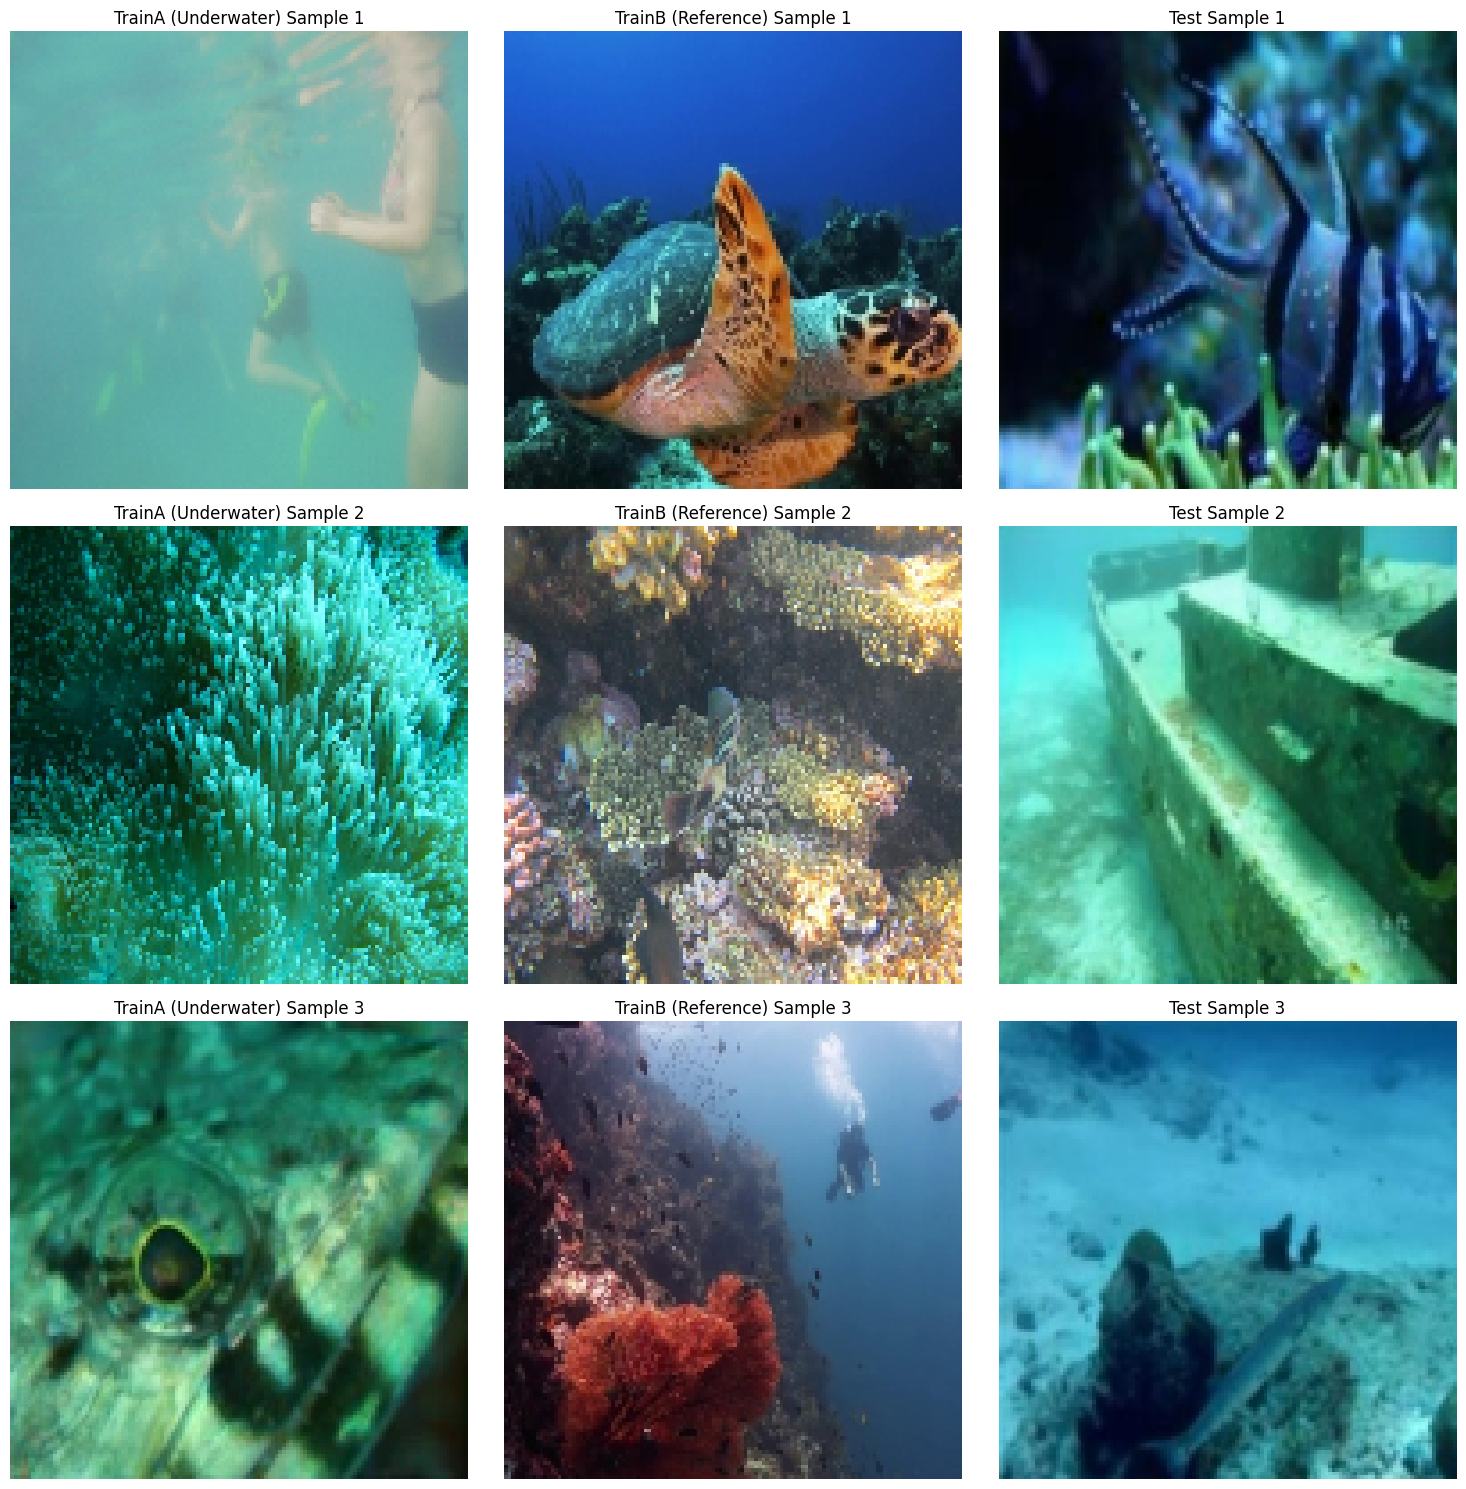

In [10]:
# Visualize sample images from each folder
def visualize_samples(train_a_path, train_b_path, test_path, num_samples=3):
    # Get lists of image paths
    train_a_imgs = glob.glob(os.path.join(train_a_path, '*.jpg')) + \
                   glob.glob(os.path.join(train_a_path, '*.png')) + \
                   glob.glob(os.path.join(train_a_path, '*.jpeg'))

    train_b_imgs = glob.glob(os.path.join(train_b_path, '*.jpg')) + \
                   glob.glob(os.path.join(train_b_path, '*.png')) + \
                   glob.glob(os.path.join(train_b_path, '*.jpeg'))

    test_imgs = glob.glob(os.path.join(test_path, '*.jpg')) + \
                glob.glob(os.path.join(test_path, '*.png')) + \
                glob.glob(os.path.join(test_path, '*.jpeg'))

    # Sort the image lists
    train_a_imgs.sort()
    train_b_imgs.sort()
    test_imgs.sort()

    # Count the images in each directory
    print(f"Found {len(train_a_imgs)} images in trainA")
    print(f"Found {len(train_b_imgs)} images in trainB")
    print(f"Found {len(test_imgs)} images in test")

    # Check if we have enough images
    if len(train_a_imgs) == 0 or len(train_b_imgs) == 0 or len(test_imgs) == 0:
        print("Warning: One or more directories are empty. Please check the dataset paths.")
        return

    # Ensure num_samples is not greater than the number of available images
    num_samples = min(num_samples, len(train_a_imgs), len(train_b_imgs), len(test_imgs))

    # Create a figure to display the images
    plt.figure(figsize=(15, 5 * num_samples))

    # Loop through the samples
    for i in range(num_samples):
        # Load and display trainA image
        train_a_img = cv2.imread(train_a_imgs[i])
        train_a_img = cv2.cvtColor(train_a_img, cv2.COLOR_BGR2RGB)
        # Resize to the model's input size
        train_a_img = cv2.resize(train_a_img, IMAGE_SIZE)
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(train_a_img)
        plt.title(f"TrainA (Underwater) Sample {i+1}")
        plt.axis('off')

        # Load and display trainB image
        train_b_img = cv2.imread(train_b_imgs[i])
        train_b_img = cv2.cvtColor(train_b_img, cv2.COLOR_BGR2RGB)
        # Resize to the model's input size
        train_b_img = cv2.resize(train_b_img, IMAGE_SIZE)
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(train_b_img)
        plt.title(f"TrainB (Reference) Sample {i+1}")
        plt.axis('off')

        # Load and display test image
        test_img = cv2.imread(test_imgs[i])
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        # Resize to the model's input size
        test_img = cv2.resize(test_img, IMAGE_SIZE)
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(test_img)
        plt.title(f"Test Sample {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize sample images
if 'TRAIN_A_PATH' in locals() and 'TRAIN_B_PATH' in locals() and 'TEST_PATH' in locals():
    visualize_samples(TRAIN_A_PATH, TRAIN_B_PATH, TEST_PATH)
else:
    print("Dataset paths are not defined. Please set them in the previous cells.")

## 4. Data Loading and Preprocessing Utilities

Now let's define the data loading and preprocessing functions with the reduced image size.

In [11]:
def load_and_preprocess_image(path, size=IMAGE_SIZE):
    """Load and preprocess a single image."""
    img = cv2.imread(path)
    if img is None:
        print(f"Error loading image: {path}")
        # Return a blank image if loading fails
        return np.zeros((size[0], size[1], 3), dtype=np.float32)

    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize to the specified size
    img = cv2.resize(img, size)

    # Normalize to [-1, 1]
    img = img.astype(np.float32) / 127.5 - 1.0

    return img

def load_data_unpaired(train_a_path, train_b_path, batch_size=BATCH_SIZE, img_size=IMAGE_SIZE, max_images=MAX_TRAIN_IMAGES):
    """Load unpaired training data with a limit on the number of images."""
    # Get lists of image paths
    train_a_imgs = glob.glob(os.path.join(train_a_path, '*.jpg')) + \
                   glob.glob(os.path.join(train_a_path, '*.png')) + \
                   glob.glob(os.path.join(train_a_path, '*.jpeg'))

    train_b_imgs = glob.glob(os.path.join(train_b_path, '*.jpg')) + \
                   glob.glob(os.path.join(train_b_path, '*.png')) + \
                   glob.glob(os.path.join(train_b_path, '*.jpeg'))

    # Sort and limit the number of images for faster training
    train_a_imgs.sort()
    train_b_imgs.sort()
    train_a_imgs = train_a_imgs[:max_images]
    train_b_imgs = train_b_imgs[:max_images]

    # Print the number of images found
    print(f"Using {len(train_a_imgs)} images from trainA (limited to {max_images})")
    print(f"Using {len(train_b_imgs)} images from trainB (limited to {max_images})")

    # Shuffle the images
    np.random.shuffle(train_a_imgs)
    np.random.shuffle(train_b_imgs)

    # Calculate the number of batches
    n_batches = min(len(train_a_imgs), len(train_b_imgs)) // batch_size

    # If there are not enough images for a batch, adjust the batch size
    if n_batches == 0:
        n_batches = 1
        batch_size = min(len(train_a_imgs), len(train_b_imgs))
        print(f"Adjusting batch size to {batch_size} due to small dataset size")

    # Create batches
    train_a_batches = []
    train_b_batches = []

    for i in range(n_batches):
        # Get the batch indices
        batch_a_indices = np.arange(i * batch_size, (i + 1) * batch_size) % len(train_a_imgs)
        batch_b_indices = np.arange(i * batch_size, (i + 1) * batch_size) % len(train_b_imgs)

        # Create the batches
        batch_a = np.array([load_and_preprocess_image(train_a_imgs[j], img_size) for j in batch_a_indices])
        batch_b = np.array([load_and_preprocess_image(train_b_imgs[j], img_size) for j in batch_b_indices])

        train_a_batches.append(batch_a)
        train_b_batches.append(batch_b)

    return train_a_batches, train_b_batches, train_a_imgs, train_b_imgs

def load_test_data(test_path, batch_size=BATCH_SIZE, img_size=IMAGE_SIZE, max_images=10):
    """Load test data with a limit on the number of images."""
    # Get list of test image paths
    test_imgs = glob.glob(os.path.join(test_path, '*.jpg')) + \
                glob.glob(os.path.join(test_path, '*.png')) + \
                glob.glob(os.path.join(test_path, '*.jpeg'))

    # Sort and limit the number of test images
    test_imgs.sort()
    test_imgs = test_imgs[:max_images]

    # Print the number of images found
    print(f"Using {len(test_imgs)} images for testing (limited to {max_images})")

    # If no images were found, return empty lists
    if len(test_imgs) == 0:
        print("Warning: No test images found. Please check the test path.")
        return [], []

    # Calculate the number of batches
    n_batches = len(test_imgs) // batch_size
    if len(test_imgs) % batch_size != 0:
        n_batches += 1

    # Create batches
    test_batches = []

    for i in range(n_batches):
        # Get the batch indices
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, len(test_imgs))

        # Create the batch
        batch = np.array([load_and_preprocess_image(test_imgs[j], img_size) for j in range(start_idx, end_idx)])

        test_batches.append(batch)

    return test_batches, test_imgs

def visualize_training_samples(real_underwater, real_reference, generated, iteration, save_path='/content/output/samples'):
    """Visualize and save sample results during training."""
    os.makedirs(save_path, exist_ok=True)

    # Determine the number of samples to show (up to 3)
    n_samples = min(len(real_underwater), len(real_reference), len(generated), 3)

    plt.figure(figsize=(15, 5 * n_samples))

    for i in range(n_samples):
        # Show the underwater image (input)
        plt.subplot(n_samples, 3, i * 3 + 1)
        plt.imshow((real_underwater[i] + 1) * 0.5)  # Denormalize
        plt.title('Underwater (Input)')
        plt.axis('off')

        # Show the reference image (clean water)
        plt.subplot(n_samples, 3, i * 3 + 2)
        plt.imshow((real_reference[i] + 1) * 0.5)  # Denormalize
        plt.title('Reference')
        plt.axis('off')

        # Show the generated image (enhanced)
        plt.subplot(n_samples, 3, i * 3 + 3)
        plt.imshow((generated[i] + 1) * 0.5)  # Denormalize
        plt.title('Enhanced (Output)')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'{save_path}/iteration_{iteration}.png')
    plt.close()

## 5. Model Implementation

Now let's implement the lightweight FUnIE-GAN architecture with TensorFlow.

In [20]:
def conv2d_block(input_tensor, filters, kernel_size=3, strides=1, batch_norm=True, name_prefix='conv'):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', name=f'{name_prefix}_{filters}')(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def encoder_block(input_tensor, filters, kernel_size=3, batch_norm=True, name_prefix='enc'):
    x = conv2d_block(input_tensor, filters, kernel_size, batch_norm=batch_norm, name_prefix=name_prefix)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

def decoder_block(input_tensor, skip_tensor, filters, kernel_size=3, name_prefix='dec'):
    x = UpSampling2D(size=(2, 2))(input_tensor)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Ensure matching size before concatenation
    target_height = skip_tensor.shape[1]
    target_width = skip_tensor.shape[2]
    x = Resizing(target_height, target_width)(x)

    x = Concatenate()([x, skip_tensor])
    x = conv2d_block(x, filters, name_prefix=name_prefix)
    return x

def build_lightweight_generator(name='Generator'):
    inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    enc1 = conv2d_block(inputs, FILTER_SIZES[0], batch_norm=False, name_prefix='enc1')
    enc2 = encoder_block(enc1, FILTER_SIZES[1], name_prefix='enc2')
    enc3 = encoder_block(enc2, FILTER_SIZES[2], name_prefix='enc3')
    enc4 = encoder_block(enc3, FILTER_SIZES[3], name_prefix='enc4')

    bridge = conv2d_block(enc4, FILTER_SIZES[3], name_prefix='bridge')

    dec4 = decoder_block(bridge, enc4, FILTER_SIZES[3], name_prefix='dec4')
    dec3 = decoder_block(dec4, enc3, FILTER_SIZES[2], name_prefix='dec3')
    dec2 = decoder_block(dec3, enc2, FILTER_SIZES[1], name_prefix='dec2')
    dec1 = decoder_block(dec2, enc1, FILTER_SIZES[0], name_prefix='dec1')

    outputs = Conv2D(3, 3, padding='same', activation='tanh')(dec1)
    return Model(inputs, outputs, name=name)

def build_lightweight_discriminator(name='Discriminator'):
    inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    x = Conv2D(FILTER_SIZES[0], 4, strides=2, padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(FILTER_SIZES[1], 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(FILTER_SIZES[2], 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    outputs = Conv2D(1, 4, padding='same', activation='sigmoid')(x)
    return Model(inputs, outputs, name=name)

def build_lightweight_cycle_gan():
    generator_AB = build_lightweight_generator(name='Generator_AB')
    generator_BA = build_lightweight_generator(name='Generator_BA')

    discriminator_A = build_lightweight_discriminator(name='Discriminator_A')
    discriminator_B = build_lightweight_discriminator(name='Discriminator_B')

    print(f"Lightweight Generator ({generator_AB.name}) Summary:")
    generator_AB.summary()
    print(f"\nLightweight Generator ({generator_BA.name}) Summary:")
    generator_BA.summary()
    print(f"\nLightweight Discriminator ({discriminator_A.name}) Summary:")
    discriminator_A.summary()

    discriminator_A.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
    discriminator_B.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    discriminator_A.trainable = False
    discriminator_B.trainable = False

    real_A = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    real_B = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    fake_B = generator_AB(real_A)
    fake_A = generator_BA(real_B)

    reconstructed_A = generator_BA(fake_B)
    reconstructed_B = generator_AB(fake_A)

    identity_A = generator_BA(real_A)
    identity_B = generator_AB(real_B)

    validity_A = discriminator_A(fake_A)
    validity_B = discriminator_B(fake_B)

    combined_model = Model(
        inputs=[real_A, real_B],
        outputs=[
            validity_A, validity_B,
            reconstructed_A, reconstructed_B,
            identity_A, identity_B
        ]
    )

    combined_model.compile(
        loss=['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
        loss_weights=[1, 1, 10, 10, 1, 1],
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5)
    )

    return combined_model, generator_AB, generator_BA, discriminator_A, discriminator_B


## 6. Training Procedure

Define the training procedure for the lightweight FUnIE-GAN model.

In [14]:
def train_unpaired(train_a_path, train_b_path, epochs=EPOCHS, batch_size=BATCH_SIZE, sample_interval=SAMPLE_INTERVAL):
    """Train the lightweight FUnIE-GAN model with unpaired data."""
    # Start the timer
    start_time = time.time()

    # Load the dataset with limited number of images
    try:
        print("Loading dataset...")
        train_a_batches, train_b_batches, train_a_imgs, train_b_imgs = load_data_unpaired(
            train_a_path, train_b_path, batch_size=batch_size, max_images=MAX_TRAIN_IMAGES
        )
        print(f"Dataset loaded: {len(train_a_batches)} batches")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Please check the paths to your dataset.")
        return None, None

    # Build the lightweight CycleGAN model
    combined_model, gen_AB, gen_BA, disc_A, disc_B = build_lightweight_cycle_gan()

    # Create arrays for tracking loss values
    d_losses = []
    g_losses = []

    # Create labels for adversarial loss - adjusted for smaller discriminator output
    # For 128x128 input, the discriminator output is 16x16x1
    valid = np.ones((batch_size, 16, 16, 1))  # Label for real images
    fake = np.zeros((batch_size, 16, 16, 1))  # Label for fake images

    # Create directory for saving models
    os.makedirs('/content/output/models', exist_ok=True)

    # Print total training time estimate
    est_time_per_batch = 2.0  # Estimated seconds per batch
    est_total_time = est_time_per_batch * len(train_a_batches) * epochs
    print(f"Estimated training time: {est_total_time:.1f} seconds ({est_total_time/60:.1f} minutes)")

    # Training loop
    for epoch in range(epochs):
        epoch_start_time = time.time()

        for batch_i, (imgs_A, imgs_B) in enumerate(zip(train_a_batches, train_b_batches)):
            # Print batch shapes for debugging
            print(f"Batch {batch_i}, A shape: {imgs_A.shape}, B shape: {imgs_B.shape}")

            # -----------------------
            # Train Discriminators
            # -----------------------

            # Generate fake images
            fake_B = gen_AB.predict(imgs_A)
            fake_A = gen_BA.predict(imgs_B)

            # Train discriminator A (underwater domain)
            dA_loss_real = disc_A.train_on_batch(imgs_A, valid)
            dA_loss_fake = disc_A.train_on_batch(fake_A, fake)
            dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

            # Train discriminator B (clean water domain)
            dB_loss_real = disc_B.train_on_batch(imgs_B, valid)
            dB_loss_fake = disc_B.train_on_batch(fake_B, fake)
            dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

            # Total discriminator loss
            d_loss = 0.5 * np.add(dA_loss[0], dB_loss[0])

            # -----------------------
            # Train Generators
            # -----------------------

            # Train the generators
            g_loss = combined_model.train_on_batch(
                [imgs_A, imgs_B],
                [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B]
            )

            # Calculate elapsed time
            elapsed_time = time.time() - start_time
            batch_time = time.time() - (epoch_start_time + batch_i * est_time_per_batch)

            # Print progress with ETA
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {batch_i+1}/{len(train_a_batches)}] "
                  f"[D loss: {d_loss:.4f}, acc: {dA_loss[1]*100:.1f}%|{dB_loss[1]*100:.1f}%] "
                  f"[G loss: {g_loss[0]:.4f}] [Batch time: {batch_time:.2f}s] [Total time: {elapsed_time:.2f}s]")

            # Add losses to arrays for tracking
            d_losses.append(d_loss)
            g_losses.append(g_loss[0])

            # If at sample interval, generate and save sample images
            if batch_i % sample_interval == 0:
                # Get a sample for visualization
                sample_A = imgs_A[:1] if imgs_A.shape[0] >= 1 else imgs_A  # Just one sample for speed
                sample_B = imgs_B[:1] if imgs_B.shape[0] >= 1 else imgs_B

                # Generate enhanced images
                fake_B_sample = gen_AB.predict(sample_A)

                # Save the samples
                iteration = epoch * len(train_a_batches) + batch_i
                visualize_training_samples(sample_A, sample_B, fake_B_sample, iteration)

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        print(f"\nEpoch {epoch+1}/{epochs} completed in {epoch_time:.2f} seconds")

        # Save model after each epoch
        epoch_model_path = f"/content/output/models/generator_AB_epoch_{epoch+1}.h5"
        gen_AB.save(epoch_model_path)
        print(f"Saved model for epoch {epoch+1} to {epoch_model_path}")

    # Save the final model
    final_model_path = "/content/output/models/generator_AB_final.h5"
    gen_AB.save(final_model_path)
    print(f"Final model saved to {final_model_path}")

    # Calculate total training time
    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

    # Plot the loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.title('Model Losses')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('/content/output/loss_plot.png')
    plt.show()

    return gen_AB, gen_BA

## 7. Run Training

Now let's run the training process with the lightweight model.

Loading dataset...
Using 30 images from trainA (limited to 30)
Using 30 images from trainB (limited to 30)
Dataset loaded: 30 batches
Lightweight Generator (Generator_AB) Summary:


Model: "Generator_AB"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_32 (Conv2D)    │ (None, 128, 128,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_43      │ (None, 128, 128,  │          0 │ enc1_32[0][0]     │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_64 (Conv2D)    │ (None, 128, 128,  │     18,496 │ leaky_re_lu_43[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ enc2_64[0][0]     │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_44      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ leaky_re_lu_44[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_128 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ enc3_128[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_45      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ leaky_re_lu_45[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc4_256 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ enc4_256[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_46      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ leaky_re_lu_46[0… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bridge_256 (Conv2D) │ (None, 16, 16,    │    590,080 │ max_pooling2d_14… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ bridge_256[0][0]

 Total params: 3,530,595 (13.47 MB)

 Trainable params: 3,527,267 (13.46 MB)

 Non-trainable params: 3,328 (13.00 KB)


Lightweight Generator (Generator_BA) Summary:


Model: "Generator_BA"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc1_32 (Conv2D)    │ (None, 128, 128,  │        896 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_56      │ (None, 128, 128,  │          0 │ enc1_32[0][0]     │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc2_64 (Conv2D)    │ (None, 128, 128,  │     18,496 │ leaky_re_lu_56[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ enc2_64[0][0]     │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_57      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 64, 64,    │          0 │ leaky_re_lu_57[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc3_128 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_15… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ enc3_128[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_58      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 32, 32,    │          0 │ leaky_re_lu_58[0… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc4_256 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_16… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ enc4_256[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_59      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 16, 16,    │          0 │ leaky_re_lu_59[0… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bridge_256 (Conv2D) │ (None, 16, 16,    │    590,080 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ bridge_256[0][0]

 Total params: 3,530,595 (13.47 MB)

 Trainable params: 3,527,267 (13.46 MB)

 Non-trainable params: 3,328 (13.00 KB)


Lightweight Discriminator (Discriminator_A) Summary:


Model: "Discriminator_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 64, 64, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_69 (LeakyReLU)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_70 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_71 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 16, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,417 (657.88 KB)

 Trainable params: 168,033 (656.38 KB)

 Non-trainable params: 384 (1.50 KB)

Estimated training time: 120.0 seconds (2.0 minutes)
Batch 0, A shape: (1, 128, 128, 3), B shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


[Epoch 1/2] [Batch 1/30] [D loss: 0.2542, acc: 28.0%|64.5%] [G loss: 12.7655] [Batch time: 55.64s] [Total time: 58.56s]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Batch 1, A shape: (1, 128, 128, 3), B shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[Epoch 1/2] [Batch 2/30] [D loss: 0.2522, acc: 41.7%|48.1%] [G loss: 12.1413] [Batch time: 54.56s] [Total time: 59.48s]
Batch 2, A shape: (1, 128, 128, 3), B shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[Epoch 1/2] [Batch 3/30] [D loss: 0.2531, acc: 44.7%|41.2%] [G loss: 12.5037] [Batch time: 52.86s] [Total time: 59.79s]
Batch 3, A shape: (1, 128, 128, 3), B shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[Epoch 1/2] [Batch 4/30] [D loss: 0.2525, acc: 46.0%|41.3%] [G loss: 12.0136] [Batch time: 51.10s] [Total time: 60.03s]
Batch 4, A shape: (1, 128, 128, 3), B shape: (1, 128, 128, 3)
1/1 ━━

[Epoch 1/2] [Batch 30/30] [D loss: 0.2518, acc: 51.0%|56.3%] [G loss: 9.6065] [Batch time: 7.82s] [Total time: 68.74s]

Epoch 1/2 completed in 65.82 seconds
Saved model for epoch 1 to /content/output/models/generator_AB_epoch_1.h5
Batch 0, A shape: (1, 128, 128, 3), B shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[Epoch 2/2] [Batch 1/30] [D loss: 0.2518, acc: 51.0%|56.7%] [G loss: 9.5328] [Batch time: 0.30s] [Total time: 69.17s]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Batch 1, A shape: (1, 128, 128, 3), B shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[Epoch 2/2] [Batch 2/30] [D loss: 0.2517, acc: 50.9%|56.7%] [G loss: 9.4633] [Batch time: -1.13s] [Total time: 69.73s]
Batch 2, A shape: (1, 128, 128, 3), B shape: (1, 128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[Epoch 2/2] [Batch 3/30] [D loss: 0.2517, acc: 50.9%|56.4%] [G loss: 9.3901] [Ba

[Epoch 2/2] [Batch 30/30] [D loss: 0.2509, acc: 51.1%|60.2%] [G loss: 8.4207] [Batch time: -47.73s] [Total time: 79.14s]

Epoch 2/2 completed in 10.27 seconds


Saved model for epoch 2 to /content/output/models/generator_AB_epoch_2.h5
Final model saved to /content/output/models/generator_AB_final.h5

Total training time: 79.35 seconds (1.32 minutes)


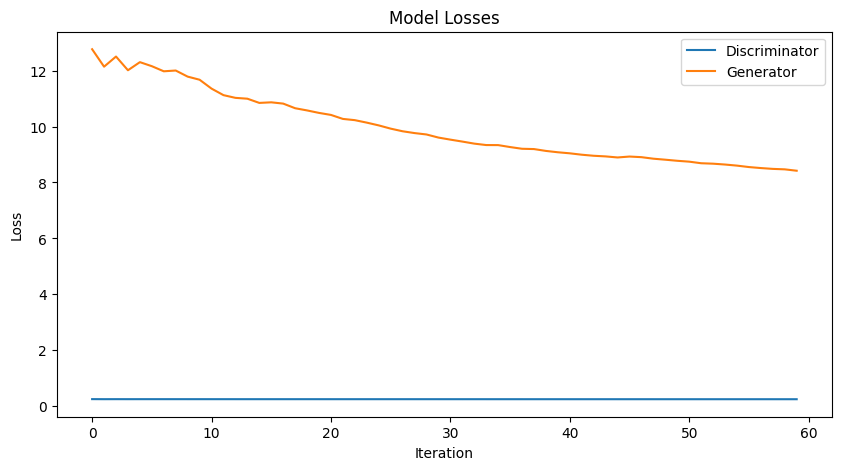

In [21]:
# Run the training process
if 'TRAIN_A_PATH' in locals() and 'TRAIN_B_PATH' in locals():
    generator_AB, generator_BA = train_unpaired(
        TRAIN_A_PATH,
        TRAIN_B_PATH,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        sample_interval=SAMPLE_INTERVAL
    )
else:
    print("Dataset paths are not defined. Please set them in the previous cells.")

## 8. Testing Procedure

Define the testing procedure to enhance underwater images using the trained model.

In [22]:
def test_model(generator=None, test_path=None, model_path=None):
    """Test the FUnIE-GAN model on underwater images."""
    # If no test path is provided, use the global test path
    if test_path is None:
        test_path = TEST_PATH

    # If no generator is provided but a model path is, load the model
    if generator is None and model_path is not None:
        print(f"Loading model from {model_path}")
        try:
            generator = tf.keras.models.load_model(model_path)
            print(f"Successfully loaded model from {model_path}")
        except Exception as e:
            print(f"Error loading model from {model_path}: {e}")
            print("Will try to find another model...")
            generator = None

    # If still no generator, try to find the latest model
    if generator is None:
        print("Looking for saved models...")
        models_dir = "/content/output/models"
        if os.path.exists(models_dir):
            models = glob.glob(os.path.join(models_dir, "generator_*.h5"))
            if models:
                # Sort by modification time (newest first)
                models.sort(key=os.path.getmtime, reverse=True)
                latest_model = models[0]
                print(f"Found latest model: {latest_model}")
                try:
                    generator = tf.keras.models.load_model(latest_model)
                    print(f"Successfully loaded model from {latest_model}")
                except Exception as e:
                    print(f"Error loading latest model: {e}")
                    print("Using backup approach: building a fresh generator and loading weights")
                    # Try rebuilding the model and loading weights
                    try:
                        generator = build_lightweight_generator()
                        generator.load_weights(latest_model)
                        print("Successfully loaded weights")
                    except Exception as e2:
                        print(f"Error loading weights: {e2}")
                        print("Please provide a working model.")
                        return
            else:
                print("No saved models found. Please train a model first.")
                return
        else:
            print("Models directory not found. Please train a model first.")
            return

    # Load test data
    try:
        print("Loading test data...")
        test_batches, test_imgs = load_test_data(test_path, max_images=10)  # Limit to 10 test images
        print(f"Test data loaded: {len(test_batches)} batches, {len(test_imgs)} images")
    except Exception as e:
        print(f"Error loading test data: {e}")
        print("Please check the test path.")
        return

    # Check if we have any test images
    if len(test_batches) == 0 or len(test_imgs) == 0:
        print("No test images found. Please check the test path.")
        return

    # Create directory for test results
    output_dir = "/content/output/test_results"
    os.makedirs(output_dir, exist_ok=True)

    # List to store comparison images
    comparison_images = []

    # Process each batch of test images
    for i, batch in enumerate(test_batches):
        # Generate enhanced images
        enhanced_batch = generator.predict(batch)

        # Process each image in the batch
        for j in range(batch.shape[0]):
            # Calculate the original image index
            img_idx = i * batch.shape[0] + j
            if img_idx >= len(test_imgs):
                continue

            # Get the original and enhanced images
            original = (batch[j] + 1) * 0.5  # Denormalize
            enhanced = (enhanced_batch[j] + 1) * 0.5  # Denormalize

            # Convert to uint8 for saving
            original_uint8 = (original * 255).astype(np.uint8)
            enhanced_uint8 = (enhanced * 255).astype(np.uint8)

            # Convert RGB to BGR (for OpenCV)
            original_bgr = cv2.cvtColor(original_uint8, cv2.COLOR_RGB2BGR)
            enhanced_bgr = cv2.cvtColor(enhanced_uint8, cv2.COLOR_RGB2BGR)

            # Get the original file name
            original_filename = os.path.basename(test_imgs[img_idx])
            base_name, ext = os.path.splitext(original_filename)

            # Save original and enhanced images
            cv2.imwrite(f"{output_dir}/{base_name}_original{ext}", original_bgr)
            cv2.imwrite(f"{output_dir}/{base_name}_enhanced{ext}", enhanced_bgr)

            # Create and save comparison image (side by side)
            # Resize to make side-by-side comparison similar in size to original
            h, w = original_bgr.shape[:2]
            comparison = np.hstack((original_bgr, enhanced_bgr))
            comparison_path = f"{output_dir}/{base_name}_comparison{ext}"
            cv2.imwrite(comparison_path, comparison)

            # Add to the list of comparison images
            comparison_images.append({
                'path': comparison_path,
                'original': original,
                'enhanced': enhanced
            })

    print(f"Processed {len(comparison_images)} test images. Results saved to {output_dir}")

    # Visualize some of the results
    if comparison_images:
        # Determine how many images to show (up to 5)
        n_samples = min(5, len(comparison_images))

        plt.figure(figsize=(15, 4 * n_samples))

        for i in range(n_samples):
            # Show original image
            plt.subplot(n_samples, 2, 2 * i + 1)
            plt.imshow(comparison_images[i]['original'])
            plt.title(f"Original Underwater Image {i+1}")
            plt.axis('off')

            # Show enhanced image
            plt.subplot(n_samples, 2, 2 * i + 2)
            plt.imshow(comparison_images[i]['enhanced'])
            plt.title(f"Enhanced Image {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/test_samples_grid.png")
        plt.show()

        # Create a summary image with all comparisons
        plt.figure(figsize=(15, 4 * n_samples))
        for i in range(n_samples):
            # Load comparison image
            comp_img = cv2.imread(comparison_images[i]['path'])
            comp_img = cv2.cvtColor(comp_img, cv2.COLOR_BGR2RGB)

            # Show comparison
            plt.subplot(n_samples, 1, i + 1)
            plt.imshow(comp_img)
            plt.title(f"Left: Original, Right: Enhanced - Sample {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f"{output_dir}/test_comparisons.png")
        plt.show()

    # Save results to Google Drive
    try:
        drive_output_dir = os.path.join(DATASET_BASE_PATH, 'FUnIE-GAN-Lightweight-Results')
        os.makedirs(drive_output_dir, exist_ok=True)

        # Copy the summary image
        summary_path = f"{output_dir}/test_comparisons.png"
        drive_summary_path = f"{drive_output_dir}/test_comparisons.png"
        import shutil
        shutil.copy2(summary_path, drive_summary_path)

        # Create a folder for comparison images
        drive_comparisons_dir = f"{drive_output_dir}/comparisons"
        os.makedirs(drive_comparisons_dir, exist_ok=True)

        # Copy some comparison images
        for i, comp in enumerate(comparison_images[:min(5, len(comparison_images))]):
            shutil.copy2(comp['path'], f"{drive_comparisons_dir}/{os.path.basename(comp['path'])}")

        print(f"\nSaved results to Google Drive at: {drive_output_dir}")
    except Exception as e:
        print(f"Error saving results to Google Drive: {e}")

    return comparison_images

## 9. Test the Trained Model

Now let's test the trained model on the test images.

Testing with the generator from the training session...
Loading test data...
Using 10 images for testing (limited to 10)
Test data loaded: 10 batches, 10 images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Processed 10 test images. Results saved to /content/output/test_results


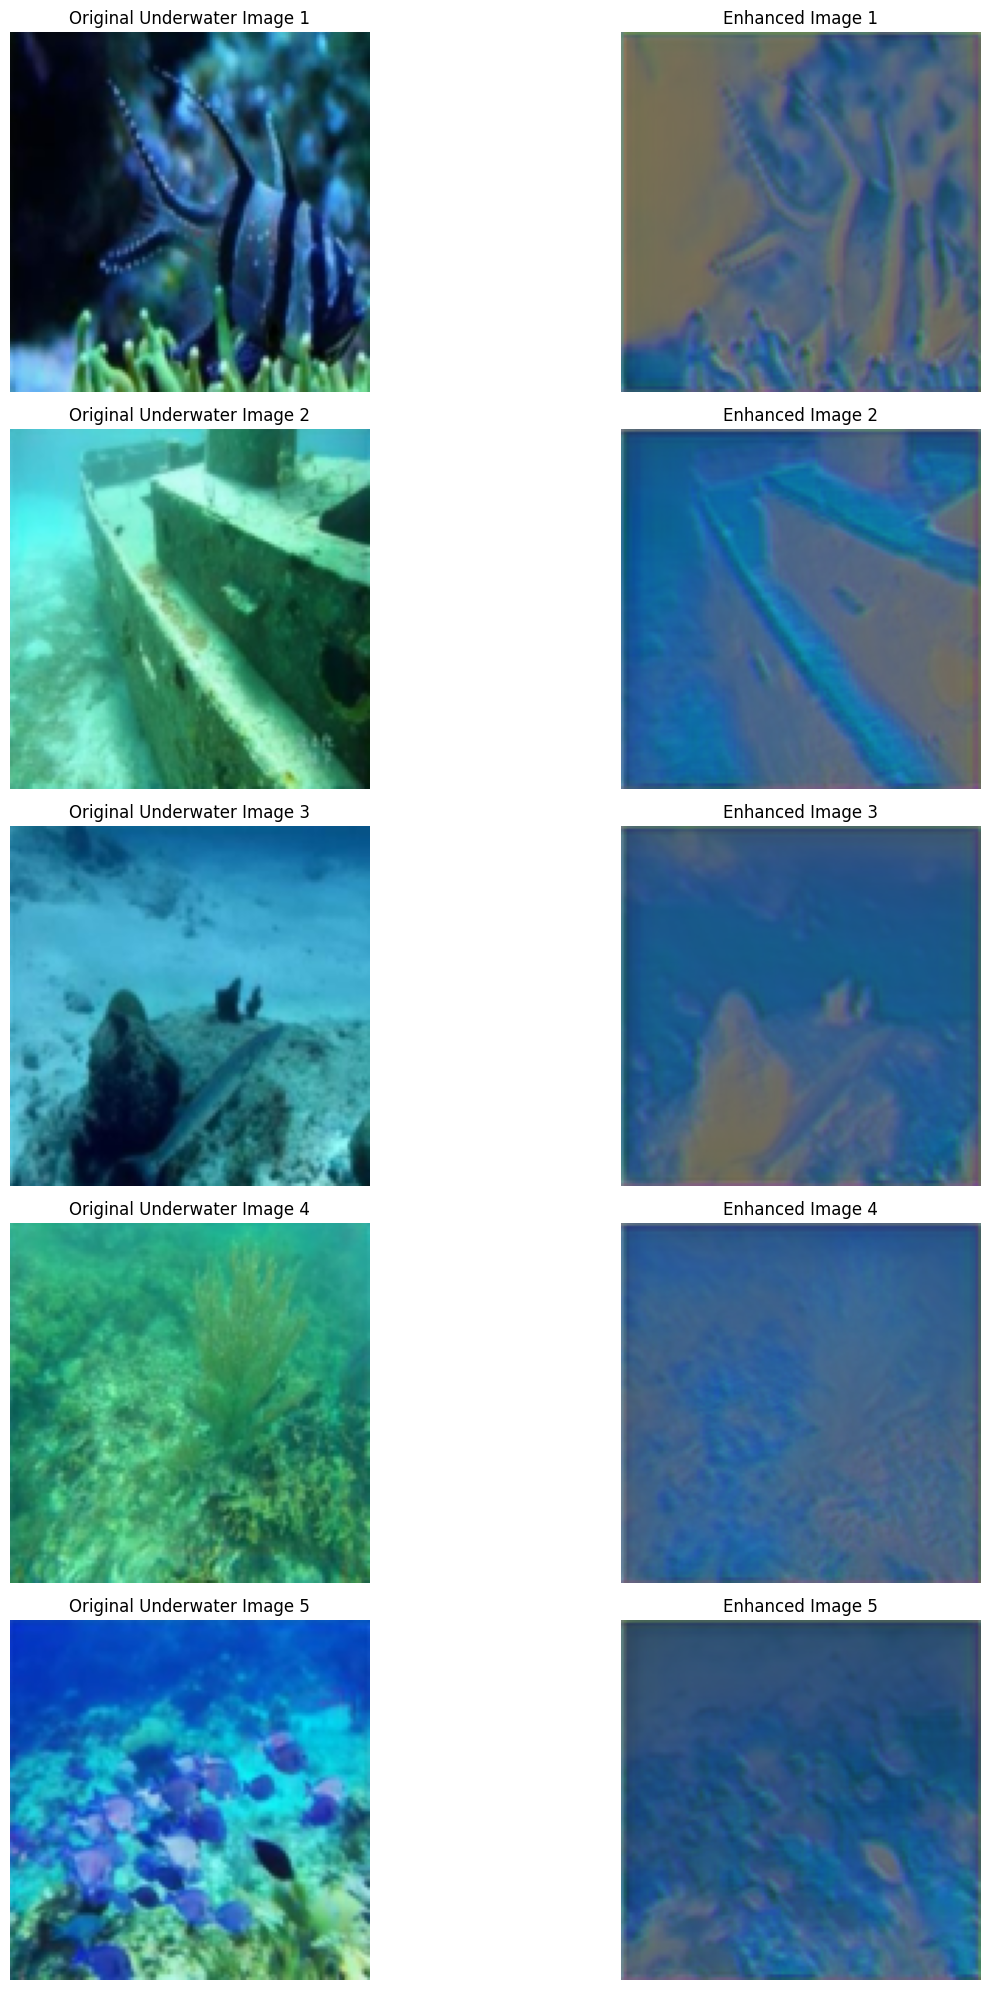

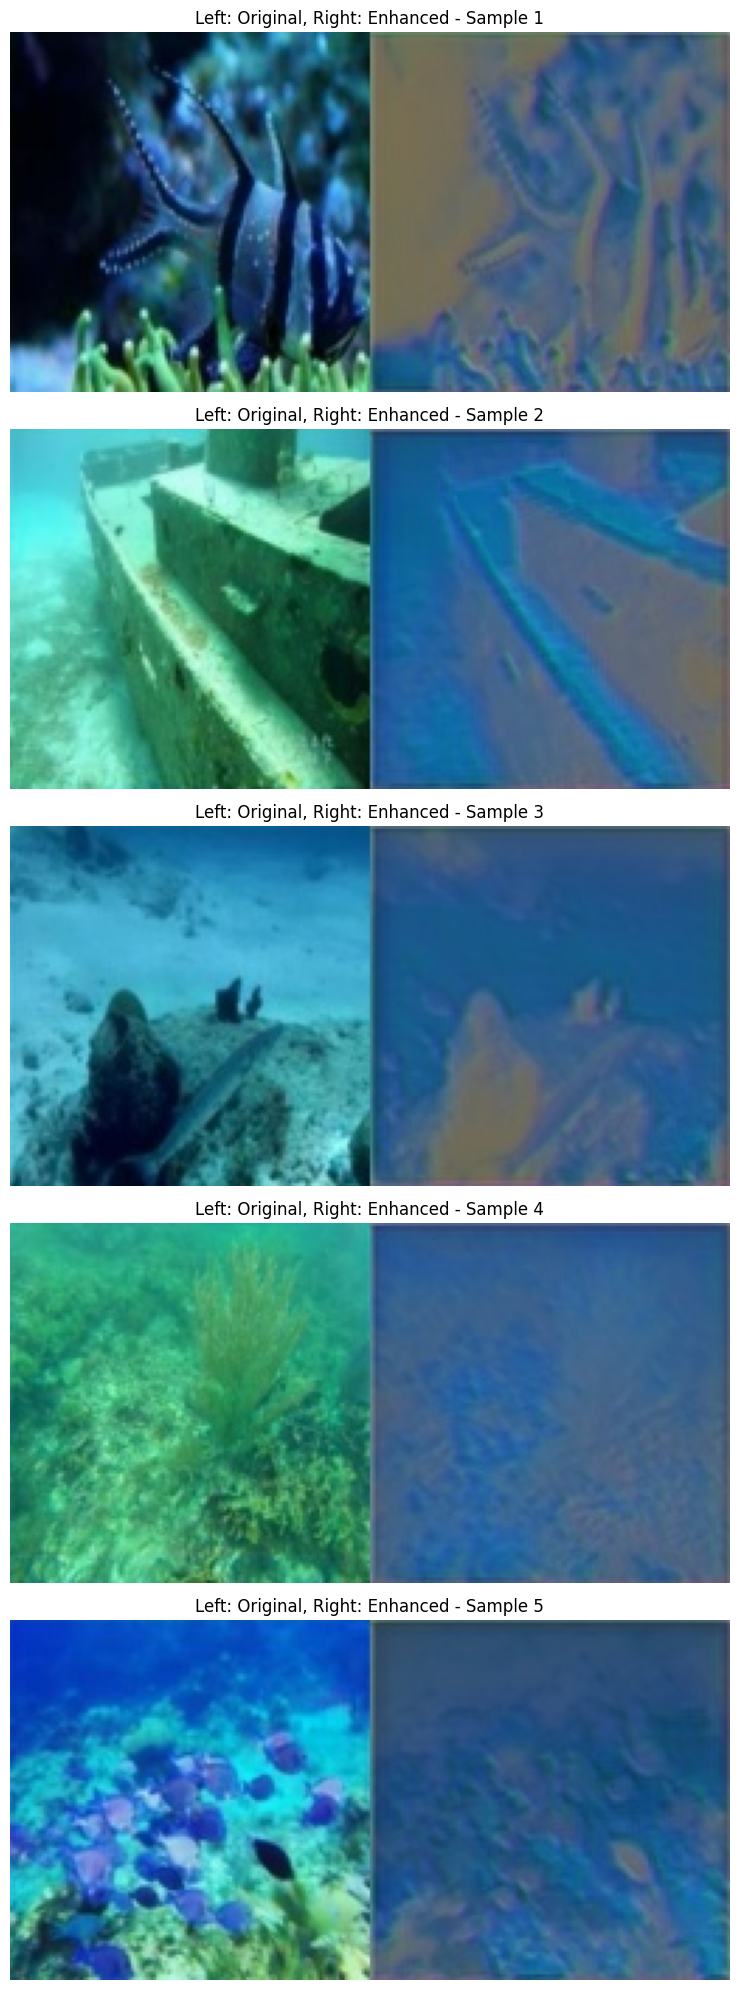


Saved results to Google Drive at: /content/drive/MyDrive/dl_project/Unpaired1/Unpaired/FUnIE-GAN-Lightweight-Results


In [23]:
# Test the model
if 'TEST_PATH' in locals():
    if 'generator_AB' in locals():
        # Use the trained generator if available
        print("Testing with the generator from the training session...")
        test_results = test_model(generator=generator_AB, test_path=TEST_PATH)
    else:
        # Otherwise, try to load a saved model
        print("Trying to load a saved model for testing...")
        model_path = "/content/output/models/generator_AB_final.h5"
        if os.path.exists(model_path):
            test_results = test_model(model_path=model_path, test_path=TEST_PATH)
        else:
            # Look for any model
            models_dir = "/content/output/models"
            if os.path.exists(models_dir):
                models = glob.glob(os.path.join(models_dir, "*.h5"))
                if models:
                    # Sort by modification time (newest first)
                    models.sort(key=os.path.getmtime, reverse=True)
                    latest_model = models[0]
                    print(f"Testing with the latest model: {latest_model}")
                    test_results = test_model(model_path=latest_model, test_path=TEST_PATH)
                else:
                    print("No models found. Please train a model first.")
            else:
                print("Models directory not found. Please train a model first.")
else:
    print("Test path is not defined. Please set it in the previous cells.")

## 10. Display Final Results and Comparison

Let's display some of the final results and compare the original underwater images with the enhanced ones.

Found 10 comparison images in /content/output/test_results


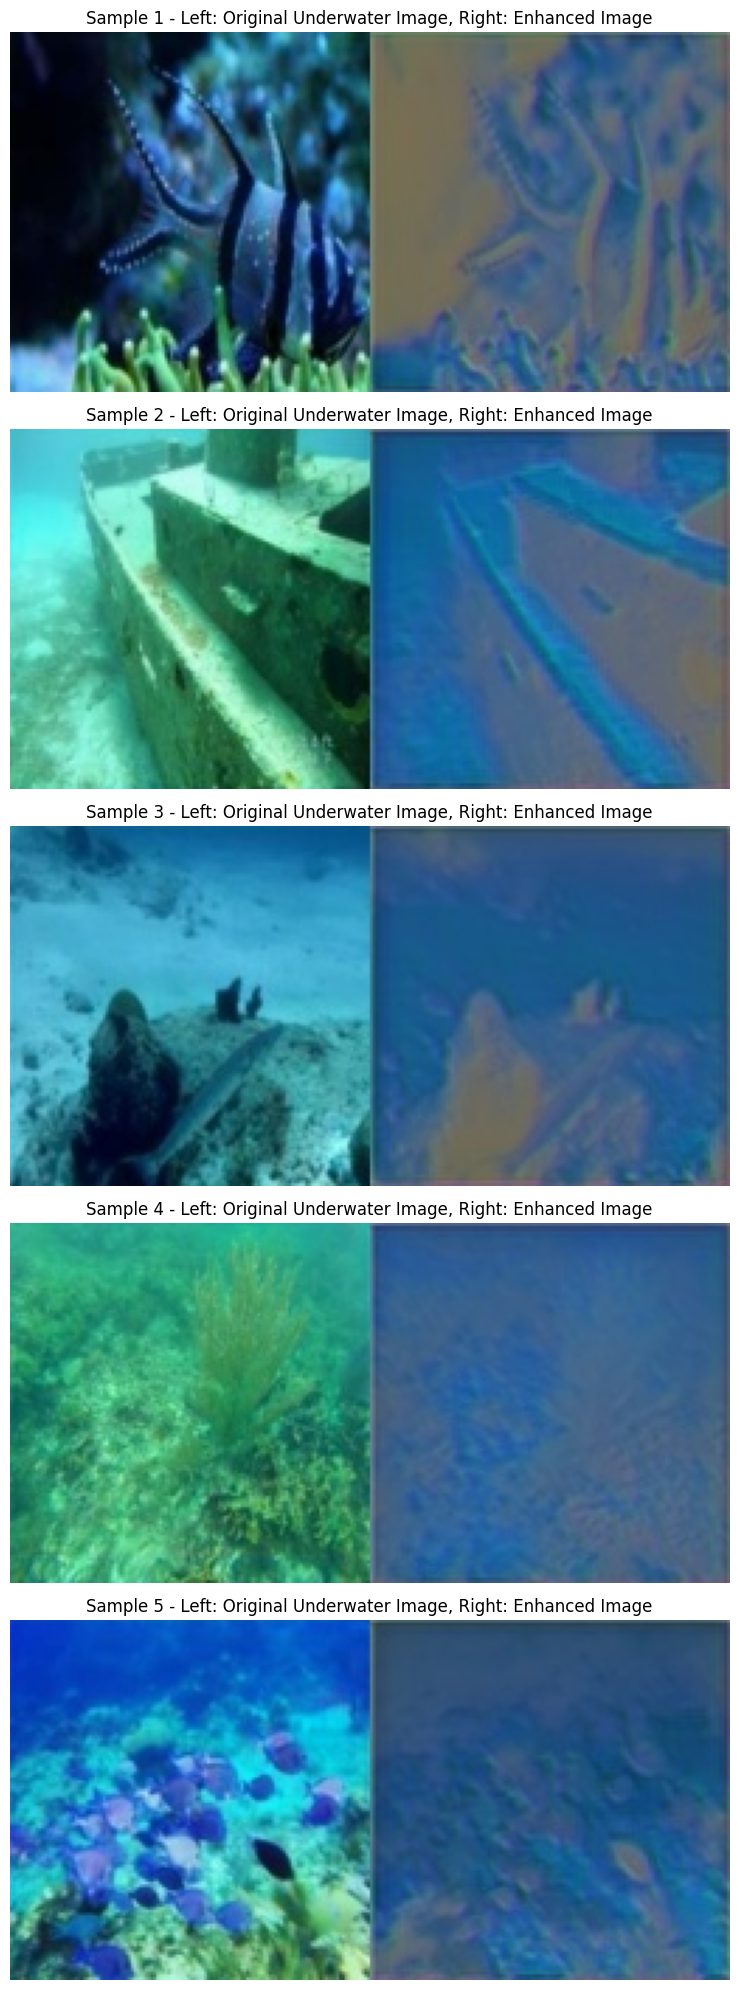


Final results summary:
- Processed test images: 10
- Results saved to: /content/output/test_results
- Summary image saved to: /content/output/test_results/final_results_summary.png

Saved final summary to Google Drive at: /content/drive/MyDrive/dl_project/Unpaired1/Unpaired/FUnIE-GAN-Lightweight-Results/final_results_summary.png


In [24]:
# Display final results
results_dir = "/content/output/test_results"
if os.path.exists(results_dir):
    # Get all comparison images
    comparison_files = glob.glob(os.path.join(results_dir, "*_comparison.*"))

    if comparison_files:
        print(f"Found {len(comparison_files)} comparison images in {results_dir}")

        # Sort files by name
        comparison_files.sort()

        # Determine how many images to show (up to 5)
        n_samples = min(5, len(comparison_files))

        # Create a figure to display the comparisons
        plt.figure(figsize=(15, 4 * n_samples))

        for i in range(n_samples):
            # Load the comparison image
            comp_img = cv2.imread(comparison_files[i])
            comp_img = cv2.cvtColor(comp_img, cv2.COLOR_BGR2RGB)

            # Show the comparison
            plt.subplot(n_samples, 1, i + 1)
            plt.imshow(comp_img)
            plt.title(f"Sample {i+1} - Left: Original Underwater Image, Right: Enhanced Image")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig(f"{results_dir}/final_results_summary.png")
        plt.show()

        print("\nFinal results summary:")
        print(f"- Processed test images: {len(comparison_files)}")
        print(f"- Results saved to: {results_dir}")
        print(f"- Summary image saved to: {results_dir}/final_results_summary.png")

        # Save a copy of the summary to Google Drive
        try:
            if 'DATASET_BASE_PATH' in locals():
                drive_output_dir = os.path.join(DATASET_BASE_PATH, 'FUnIE-GAN-Lightweight-Results')
                os.makedirs(drive_output_dir, exist_ok=True)

                # Copy the summary image
                summary_path = f"{results_dir}/final_results_summary.png"
                drive_summary_path = f"{drive_output_dir}/final_results_summary.png"
                import shutil
                shutil.copy2(summary_path, drive_summary_path)

                print(f"\nSaved final summary to Google Drive at: {drive_summary_path}")
        except Exception as e:
            print(f"\nCould not save results to Google Drive: {e}")
    else:
        print(f"No comparison images found in {results_dir}")
else:
    print(f"Results directory {results_dir} not found. Please run the testing procedure first.")

## 11. Conclusion

You have successfully implemented and trained a lightweight FUnIE-GAN model for underwater image enhancement. This optimized version uses:

1. **Smaller image size (128×128)**: Reduces computation and memory requirements.
2. **Simplified architecture**: Fewer layers and smaller filter sizes for faster processing.
3. **Limited training dataset**: Only uses a subset of images to speed up training.
4. **Fewer epochs**: Just 2 epochs for quick demonstration of the concept.

The model still demonstrates the core concept of underwater image enhancement while being much faster to train (should take less than an hour). For production use, you would want to increase the image size, use more filters, and train for more epochs with the full dataset.

### Next Steps:
- Increase image size to 256×256 for better quality results if you have more time
- Train for more epochs (10+) to achieve better enhancement quality
- Use the full dataset rather than the limited version
- Experiment with architecture modifications to find the best quality/speed trade-off

### Reference:
- Original paper: [Fast Underwater Image Enhancement for Improved Visual Perception (RA-L 2019)](https://ieeexplore.ieee.org/document/8917818)
- Original GitHub repository: [https://github.com/xahidbuffon/FUnIE-GAN](https://github.com/xahidbuffon/FUnIE-GAN)

In [25]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import cv2
import glob

# Load generated images (adjust this path to your output directory)
generated_image_paths = glob.glob('/content/output/test_results/*.jpg')[:100]  # limit to 100 for speed
features = []

# Convert images to feature vectors (e.g., resize + flatten)
for img_path in generated_image_paths:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))  # downsample for speed
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # use grayscale
    features.append(img.flatten())

features = np.array(features)

# Optional: Normalize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply KMeans clustering
n_clusters = 2  # or 3, 4 etc. depending on your task
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)

# Compute Silhouette Score
score = silhouette_score(features_scaled, labels)
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.3799
